In [1]:
import sys
import numpy as np
import pandas as pd 
from skmultiflow.data import DataStream, MultilabelGenerator, ConceptDriftStream
from skmultiflow.meta import ClassifierChain
from sklearn.linear_model import SGDClassifier
from skmultiflow.metrics import hamming_score
from sklearn.metrics import accuracy_score, f1_score
from ld3 import LD3
from skmultilearn.dataset import load_from_arff
from sklearn.preprocessing import MultiLabelBinarizer
from skmultiflow.drift_detection import ADWIN, EDDM, KSWIN, HDDM_W, HDDM_A, DDM, PageHinkley
import util
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
datasets = [('tmc2007-500.arff', 22, 6, 2500, 100, True, 10000, False)]#('Synthetic', 10, 5, 1500, 100, True, 4300, True)]#('20NG.arff', 20, 2, 2000, 100, True, 10000, False)]#('Bibtex.arff', 159, 15, 2500, 100, False, 20000, False)]#('Enron.arff', 53, 7, 200, 50, False, 2000, False)]#('Scene.arff', 6, 1, 100, 100, False, 1000, False)]

In [3]:
ks = []
for dataset, label_count, k, pretrain_size, label_window_size, big_dataset, label_store_count, sudden in datasets:
    print('Testing: {}'.format(dataset))

    if dataset == 'Synthetic':
        sample_size = 50000
        n_features=50
        if sudden:
            width = 1
        else:
            width = 500
        s1 = MultilabelGenerator(n_samples=sample_size, n_features=n_features, n_targets=label_count, n_labels=1, random_state=0)
        s2 = MultilabelGenerator(n_samples=sample_size, n_features=n_features, n_targets=label_count, n_labels=2, random_state=0)
        stream = ConceptDriftStream(stream=s1, drift_stream=s2, position=50000, width=width, random_state=0)
        #stream = MultilabelGenerator(n_samples=sample_size, n_features=n_features, n_targets=label_count, n_labels=1, random_state=0)
        X = np.zeros((sample_size, n_features))
        y = np.zeros((sample_size, label_count))
    else:  
        print('Loading stream')
        X, y = load_from_arff('./datasets/{}'.format(dataset), label_count=label_count)
        X = X.toarray()
        y = y.toarray().astype(np.int8)
        sample_size = len(X)
        num_features = X.shape[1]
        stream = DataStream(data = X, y=y, n_targets=label_count)

        if len(np.unique(y)) > 2:
            mlb = MultiLabelBinarizer()
            y = mlb.fit_transform(y)

    label_count = y.shape[1]
    clf = ClassifierChain(SGDClassifier(n_jobs=-1, loss='hinge',  random_state=1, warm_start=True), random_state=1)
    pre_sample = [np.zeros(X.shape[1]), np.zeros(X.shape[1])]
    pre_label = [np.ones(y.shape[1]), np.zeros(y.shape[1])]

    clf.fit(np.array(pre_sample), np.array(pre_label))

    labels = []
    true_labels = []
    count = 0
    print('Starting stream')
    while stream.has_more_samples():
        try:
            sample, label = stream.next_sample()
            count += 1
            if len(sample) < 1:
                break
        except:
            break

        pred = clf.predict(sample)
        #clf.partial_fit(sample, np.array([label]))
        clf.partial_fit(sample, label)
        labels.extend(pred.astype(np.int32))
        #true_labels.extend(np.array([label]).astype(np.int32))
        true_labels.extend(label.astype(np.int32))

        if count % 100 == 0 and count != 0:
            print('Stream progress: {}/{}'.format(count, sample_size))
    print(np.array(labels).shape)
        
    #r = self.recip_rank(util.to_numpy_matrix(self.labels)).tolist()[:self.k]

120919
Stream progress: 55100/120919
Stream progress: 55200/120919
Stream progress: 55300/120919
Stream progress: 55400/120919
Stream progress: 55500/120919
Stream progress: 55600/120919
Stream progress: 55700/120919
Stream progress: 55800/120919
Stream progress: 55900/120919
Stream progress: 56000/120919
Stream progress: 56100/120919
Stream progress: 56200/120919
Stream progress: 56300/120919
Stream progress: 56400/120919
Stream progress: 56500/120919
Stream progress: 56600/120919
Stream progress: 56700/120919
Stream progress: 56800/120919
Stream progress: 56900/120919
Stream progress: 57000/120919
Stream progress: 57100/120919
Stream progress: 57200/120919
Stream progress: 57300/120919
Stream progress: 57400/120919
Stream progress: 57500/120919
Stream progress: 57600/120919
Stream progress: 57700/120919
Stream progress: 57800/120919
Stream progress: 57900/120919
Stream progress: 58000/120919
Stream progress: 58100/120919
Stream progress: 58200/120919
Stream progress: 58300/120919
Str

In [4]:
mat = np.array(util.to_numpy_matrix(labels))
sum_ = np.sum(mat, axis=0)
#all = np.sum(sum_)
#sum_ = sum_ * 100
#sum_ = sum_ / all 
sorted_indexes = np.flip(np.argsort(sum_)).astype(str)
sum_ = np.flip(np.sort(sum_))



In [5]:
accuracy_score(true_labels, labels)

0.07528180021336597

In [6]:
plt.close()
plt.plot(np.arange(len(sorted_indexes)), sum_, markevery=[3], marker='o', markersize=8)
plt.annotate('k = 3', (6, 3359))
plt.xlabel('Number of labels')
plt.ylabel('Sorted number of co-occurances')
#plt.savefig('synthetic_bibtex.png', dpi=1000)
plt.close()

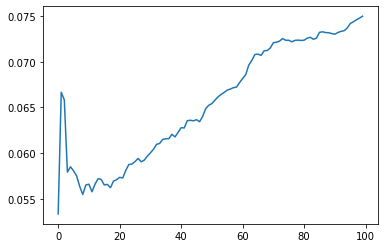

In [16]:
interval = 1200
accs = [accuracy_score(true_labels[:(i+1)*interval], labels[:(i+1)*interval]) for i in range(len(labels)//interval)]
plt.close()
plt.plot(np.arange(len(accs)), accs)
plt.show()
plt.close()

In [8]:
np.sum(true_labels)/len(true_labels)

1.999669200043004

In [9]:
np.sum(np.array(true_labels)/40)/len(true_labels)

0.04999173000107509